In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
import geopandas as gpd
from haversine import haversine, Unit
from shapely.ops import nearest_points
from tqdm import tqdm
tqdm.pandas()

### Read in input DFs: Census Demongraphics By Block Group and Geographic Boundaries of Counties

In [64]:
census_df = pd.read_csv('../input_data/census_bg_demographics.csv')

In [65]:
census_df

,census_bg,total_population,pop_0_21,pop_22_39,pop_40_59,pop_60_100,white,black,american_indian,asian,hispanic,below_high_school,high_school,some_college_associate,college,graduate_school,median_income
0,10010201001,636,0.246855,0.250000,0.279874,0.223270,0.858491,0.069182,0.000000,0.000000,0.022013,0.117225,0.428230,0.258373,0.093301,0.102871,26579.0
1,10010201002,1287,0.281274,0.209790,0.356643,0.152292,0.825952,0.090909,0.000000,0.013209,0.041958,0.025989,0.355932,0.247458,0.222599,0.148023,82750.0
2,10010202001,810,0.285185,0.151852,0.298765,0.264198,0.323457,0.643210,0.000000,0.000000,0.033333,0.042254,0.617958,0.232394,0.098592,0.008803,27500.0
3,10010202002,1218,0.238095,0.284893,0.334154,0.142857,0.457307,0.499179,0.000000,0.015599,0.007389,0.061714,0.459429,0.272000,0.144000,0.062857,49276.0
4,10010203001,2641,0.271109,0.304051,0.245362,0.179477,0.659599,0.179856,0.000000,0.011359,0.113215,0.072472,0.401839,0.335316,0.097350,0.093023,58235.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220328,560459511001,1435,0.236934,0.199303,0.226481,0.337282,0.880836,0.023693,0.000000,0.020906,0.022997,0.068695,0.484789,0.276742,0.111874,0.057900,40382.0
220329,560459511002,1851,0.195570,0.213938,0.292274,0.298217,0.940573,0.001080,0.001621,0.035116,0.031875,0.015797,0.399725,0.374313,0.125000,0.085165,53988.0
220330,560459513001,1225,0.330612,0.271837,0.206531,0.191020,1.000000,0.000000,0.000000,0.000000,0.000000,0.020177,0.385876,0.480454,0.083228,0.030265,44872.0
220331,560459513002,1214,0.170511,0.206755,0.223229,0.399506,0.971993,0.000000,0.028007,0.000000,0.001647,0.046697,0.317768,0.395216,0.223235,0.017084,60125.0


In [10]:
bonudary_df = gpd.read_file('../input_data/Census_bg_boundary.shp')

In [11]:
bonudary_df.head()

,OBJECTID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,BLKGRP,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,HISPANIC,OTHER,MULT_RACE,MALES,FEMALES,AGE_UNDER5,AGE_5_9,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_65_74,AGE_75_84,AGE_85_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,geometry
0,1,15,003,15003,981200,1,150039812001,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0.00,0,0,0,0,3.10,0.459320,0.000724,"MULTIPOLYGON (((-161.93000 23.06562, -161.9297..."
1,2,15,009,15009,031801,2,150090318012,1672,39.2,1620,38.0,156,6,1,269,440,109,6,742,824,796,126,134,136,143,98,178,188,213,191,130,52,31,34.7,32.6,36.6,472,3.39,38,39,129,128,22,52,371,3.82,542,70,347,125,42.62,1.023727,0.009600,"POLYGON ((-157.01409 21.18396, -157.01402 21.1..."
2,3,15,003,15003,000500,3,150030005003,908,4323.8,917,4366.7,371,1,1,364,25,20,2,153,443,474,34,56,62,57,29,98,96,139,169,77,61,39,47.0,45.6,48.3,322,2.85,17,32,90,126,2,10,248,3.10,385,63,253,69,0.21,0.039725,0.000048,"POLYGON ((-157.78349 21.26293, -157.78370 21.2..."
3,4,15,003,15003,000500,5,150030005005,984,4278.3,972,4226.1,359,5,1,446,24,19,0,137,480,492,47,55,69,54,34,78,126,173,160,97,54,25,46.6,46.5,46.8,346,2.81,22,32,108,136,8,6,275,3.10,396,50,263,83,0.23,0.029951,0.000052,"POLYGON ((-157.78600 21.27242, -157.78594 21.2..."
4,5,15,003,15003,000600,1,150030006001,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0.00,1,1,0,0,0.81,0.058842,0.000183,"POLYGON ((-157.79905 21.26782, -157.79908 21.2..."


### Dataframe of boundaries of all parks

In [12]:
parks_geo = pd.read_pickle('../../21_6_6_/notebooks/all_parks_df.pkl')

In [13]:
parks_geo = parks_geo.reset_index(drop=True)

### Change CRS to calculate distance and add midpoint

In [14]:
bound_df = bonudary_df.to_crs(epsg=3395).copy()

In [15]:
len(bound_df)

219831

In [16]:
bound_df['cent'] = bound_df.centroid

In [17]:
parks_geo_df = parks_geo.to_crs(epsg=3395).copy()

In [18]:
parks_geo_df['cent'] = parks_geo_df['geometry'].centroid

### For each block group, find nearest park in km

In [547]:
def min_distance(county):
    return np.min(parks_geo_df['cent'].apply(lambda x : county.distance(x) / 1000))

In [548]:
%%time
bound_df['nearest_park_dist_km'] = bound_df['cent'].progress_apply(min_distance)

100%|██████████| 219831/219831 [12:08:52<00:00,  5.03it/s]  


CPU times: user 12h 3min, sys: 4min 38s, total: 12h 7min 38s
Wall time: 12h 8min 53s


In [551]:
bound_df.head()

,OBJECTID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,BLKGRP,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,HISPANIC,OTHER,MULT_RACE,MALES,FEMALES,AGE_UNDER5,AGE_5_9,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_65_74,AGE_75_84,AGE_85_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,geometry,cent,nearest_park_dist_km
0,1,15,003,15003,981200,1,150039812001,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0.00,0,0,0,0,3.10,0.459320,0.000724,"MULTIPOLYGON (((-18025965.475 2623221.913, -18...",POINT (-19140950.776 2967072.806),120.179701
1,2,15,009,15009,031801,2,150090318012,1672,39.2,1620,38.0,156,6,1,269,440,109,6,742,824,796,126,134,136,143,98,178,188,213,191,130,52,31,34.7,32.6,36.6,472,3.39,38,39,129,128,22,52,371,3.82,542,70,347,125,42.62,1.023727,0.009600,"POLYGON ((-17478729.099 2398393.083, -17478720...",POINT (-17486277.638 2396821.829),7.875926
2,3,15,003,15003,000500,3,150030005003,908,4323.8,917,4366.7,371,1,1,364,25,20,2,153,443,474,34,56,62,57,29,98,96,139,169,77,61,39,47.0,45.6,48.3,322,2.85,17,32,90,126,2,10,248,3.10,385,63,253,69,0.21,0.039725,0.000048,"POLYGON ((-17564377.317 2407769.743, -17564400...",POINT (-17564966.407 2407755.518),0.569073
3,4,15,003,15003,000500,5,150030005005,984,4278.3,972,4226.1,359,5,1,446,24,19,0,137,480,492,47,55,69,54,34,78,126,173,160,97,54,25,46.6,46.5,46.8,346,2.81,22,32,108,136,8,6,275,3.10,396,50,263,83,0.23,0.029951,0.000052,"POLYGON ((-17564656.625 2408896.307, -17564650...",POINT (-17564420.594 2408342.570),0.271945
4,5,15,003,15003,000600,1,150030006001,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0.00,1,1,0,0,0.81,0.058842,0.000183,"POLYGON ((-17566109.786 2408349.629, -17566113...",POINT (-17566949.702 2407740.482),0.035948


### Convert coords back to degrees

In [553]:
bound_df_degrees = bound_df.to_crs(epsg=4326).copy()

In [563]:
bound_df_degrees['nearest_park_dist_km'].mean()

6.369110921174899

In [643]:
bound_df_degrees.to_csv('bound_df_all_parks.csv')

### Find nearest park to block group, by park type

In [19]:
parks_geo_df['FEATTYPE'].value_counts()

Local park       33828
State park        3989
Regional park     1910
County park       1148
National park      550
Name: FEATTYPE, dtype: int64

In [20]:
park_types_dfs = []
for x in parks_geo_df['FEATTYPE'].unique():
    parks_feat = parks_geo_df[parks_geo_df['FEATTYPE']== x].copy()
    park_types_dfs.append(parks_feat)

In [22]:
def min_distance(county):
    min_dists = []
    for park_type in park_types_dfs:
        min_dists.append(np.min(park_type['cent'].apply(lambda x : county.distance(x) / 1000)))
    return min_dists

In [24]:
%%time
bound_df['nearest_park_feattype'] = bound_df['cent'].progress_apply(min_distance)

100%|██████████| 219831/219831 [13:31:30<00:00,  4.51it/s]      

CPU times: user 6h 50min 5s, sys: 1min 46s, total: 6h 51min 51s
Wall time: 13h 31min 30s


In [25]:
bound_df['nearest_local_park'] = bound_df['nearest_park_feattype'].apply(lambda x: x[0])
bound_df['nearest_state_park'] = bound_df['nearest_park_feattype'].apply(lambda x: x[1])
bound_df['nearest_regional_park'] = bound_df['nearest_park_feattype'].apply(lambda x: x[2])
bound_df['nearest_county_park'] = bound_df['nearest_park_feattype'].apply(lambda x: x[3])
bound_df['nearest_national_park'] = bound_df['nearest_park_feattype'].apply(lambda x: x[4])

In [34]:
len(bound_df_deg)

219831

In [35]:
len(bound_df_park_type)

219831

In [31]:
bound_df_park_type = bound_df.to_crs(epsg=4326).copy()

In [36]:
bound_df_park_type.head()

,OBJECTID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,BLKGRP,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,HISPANIC,OTHER,MULT_RACE,MALES,FEMALES,AGE_UNDER5,AGE_5_9,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_65_74,AGE_75_84,AGE_85_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,geometry,cent,nearest_park_feattype,nearest_local_park,nearest_state_park,nearest_regional_park,nearest_county_park,nearest_national_park
0,1,15,003,15003,981200,1,150039812001,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0.00,0,0,0,0,3.10,0.459320,0.000724,"MULTIPOLYGON (((-161.93000 23.06562, -161.9297...",POINT (-19140950.776 2967072.806),"[1441.0959956192028, 1651.3238527149856, 120.1...",1441.095996,1651.323853,120.179701,1432.853724,1455.974114
1,2,15,009,15009,031801,2,150090318012,1672,39.2,1620,38.0,156,6,1,269,440,109,6,742,824,796,126,134,136,143,98,178,188,213,191,130,52,31,34.7,32.6,36.6,472,3.39,38,39,129,128,22,52,371,3.82,542,70,347,125,42.62,1.023727,0.009600,"POLYGON ((-157.01409 21.18396, -157.01402 21.1...",POINT (-17486277.638 2396821.829),"[18.90038249229989, 15.006346648112482, 25.478...",18.900382,15.006347,25.478857,7.875926,73.007173
2,3,15,003,15003,000500,3,150030005003,908,4323.8,917,4366.7,371,1,1,364,25,20,2,153,443,474,34,56,62,57,29,98,96,139,169,77,61,39,47.0,45.6,48.3,322,2.85,17,32,90,126,2,10,248,3.10,385,63,253,69,0.21,0.039725,0.000048,"POLYGON ((-157.78349 21.26293, -157.78370 21.2...",POINT (-17564966.407 2407755.518),"[0.5690727631838154, 21.665726814788353, 6.932...",0.569073,21.665727,6.932676,1.980487,39.929376
3,4,15,003,15003,000500,5,150030005005,984,4278.3,972,4226.1,359,5,1,446,24,19,0,137,480,492,47,55,69,54,34,78,126,173,160,97,54,25,46.6,46.5,46.8,346,2.81,22,32,108,136,8,6,275,3.10,396,50,263,83,0.23,0.029951,0.000052,"POLYGON ((-157.78600 21.27242, -157.78594 21.2...",POINT (-17564420.594 2408342.570),"[0.2719448629534667, 21.804082677620332, 7.247...",0.271945,21.804083,7.247063,2.604952,40.287735
4,5,15,003,15003,000600,1,150030006001,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0.00,1,1,0,0,0.81,0.058842,0.000183,"POLYGON ((-157.79905 21.26782, -157.79908 21.2...",POINT (-17566949.702 2407740.482),"[0.8356366867736786, 20.061673539877013, 5.170...",0.835637,20.061674,5.170424,0.035948,38.040405


In [32]:
bound_df_park_type.to_csv('bound_df_park_type.csv')

In [55]:
bound_df_degrees = pd.read_csv('bound_df_all_parks.csv')

### Explore difference in access to parks per majority race in counties -- all minority vs white counties 

In [67]:
census_df.head()

,census_bg,total_population,pop_0_21,pop_22_39,pop_40_59,pop_60_100,white,black,american_indian,asian,hispanic,below_high_school,high_school,some_college_associate,college,graduate_school,median_income
0,10010201001,636,0.246855,0.250000,0.279874,0.223270,0.858491,0.069182,0.0,0.000000,0.022013,0.117225,0.428230,0.258373,0.093301,0.102871,26579.0
1,10010201002,1287,0.281274,0.209790,0.356643,0.152292,0.825952,0.090909,0.0,0.013209,0.041958,0.025989,0.355932,0.247458,0.222599,0.148023,82750.0
2,10010202001,810,0.285185,0.151852,0.298765,0.264198,0.323457,0.643210,0.0,0.000000,0.033333,0.042254,0.617958,0.232394,0.098592,0.008803,27500.0
3,10010202002,1218,0.238095,0.284893,0.334154,0.142857,0.457307,0.499179,0.0,0.015599,0.007389,0.061714,0.459429,0.272000,0.144000,0.062857,49276.0
4,10010203001,2641,0.271109,0.304051,0.245362,0.179477,0.659599,0.179856,0.0,0.011359,0.113215,0.072472,0.401839,0.335316,0.097350,0.093023,58235.0


In [68]:
census_df_white = census_df[census_df['white']>=0.5]
census_df_minority = census_df[census_df['white']<0.5]

In [69]:
bound_df_degrees_filt = bound_df_degrees[['OBJECTID', 'STATE_FIPS','CNTY_FIPS', 'STCOFIPS', 'TRACT',
                                         'BLKGRP', 'FIPS', 'POPULATION', 'POP_SQMI', 'WHITE', 'BLACK',
                                          'ASIAN','HAWN_PI','HISPANIC','OTHER','SQMI', 'Shape_Leng',
                                         'Shape_Area','geometry', 'cent', 'nearest_park_dist_km']].copy()

In [70]:
majority_white_df = (census_df_white.merge(bound_df_degrees_filt, left_on="census_bg",
                                          right_on="FIPS", how='inner'))

In [71]:
majority_white_df['nearest_park_dist_km'].mean()

6.8565790962075805

In [72]:
majority_white_df['nearest_park_dist_km'].median()

2.5938725349128844

In [73]:
minority_df = (census_df_minority.merge(bound_df_degrees_filt, left_on="census_bg",
                                          right_on="FIPS", how='inner'))

In [74]:
minority_df['nearest_park_dist_km'].mean()

4.250678737781346

In [75]:
minority_df['nearest_park_dist_km'].median()

1.2802178759379923

### Explore difference in access to parks per majority race in counties -- per minority race vs white counties 

In [76]:
census_df.head()

,census_bg,total_population,pop_0_21,pop_22_39,pop_40_59,pop_60_100,white,black,american_indian,asian,hispanic,below_high_school,high_school,some_college_associate,college,graduate_school,median_income
0,10010201001,636,0.246855,0.250000,0.279874,0.223270,0.858491,0.069182,0.0,0.000000,0.022013,0.117225,0.428230,0.258373,0.093301,0.102871,26579.0
1,10010201002,1287,0.281274,0.209790,0.356643,0.152292,0.825952,0.090909,0.0,0.013209,0.041958,0.025989,0.355932,0.247458,0.222599,0.148023,82750.0
2,10010202001,810,0.285185,0.151852,0.298765,0.264198,0.323457,0.643210,0.0,0.000000,0.033333,0.042254,0.617958,0.232394,0.098592,0.008803,27500.0
3,10010202002,1218,0.238095,0.284893,0.334154,0.142857,0.457307,0.499179,0.0,0.015599,0.007389,0.061714,0.459429,0.272000,0.144000,0.062857,49276.0
4,10010203001,2641,0.271109,0.304051,0.245362,0.179477,0.659599,0.179856,0.0,0.011359,0.113215,0.072472,0.401839,0.335316,0.097350,0.093023,58235.0


In [77]:
majority_black_df = census_df[census_df['black'] >= 0.3]
majority_amer_ind_df = census_df[census_df['american_indian'] >= 0.3]
majority_asian_df = census_df[census_df['asian'] >= 0.3]
majority_hisp_df = census_df[census_df['hispanic'] >= 0.3]

In [93]:
lis_df = []
lis_df.append(majority_black_df) # index 0 in final_dfs
lis_df.append(majority_amer_ind_df) # 1 in final_dfs
lis_df.append(majority_asian_df) # 2 in final_dfs
lis_df.append(majority_hisp_df) # 3 in final_dfs

In [94]:
minority_dfs = pd.concat(lis_df).drop_duplicates()

In [95]:
majority_white_df = (pd.merge(census_df,minority_dfs, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))

In [96]:
lis_df.append(majority_white_df) # 4 in final_dfs

In [97]:
final_dfs = []
for df in lis_df:
    merged_df = df.merge(bound_df_degrees_filt, left_on="census_bg",
                                          right_on="FIPS", how='inner')
    final_dfs.append(merged_df)

In [98]:
# majority black county
final_dfs[0]['nearest_park_dist_km'].mean()

4.8356830781310665

### Split counties by population density -- densest 45% is urban, next 45% is suburban, sparcest 10% is rural

(array([2.15506e+05, 2.77300e+03, 9.67000e+02, 4.52000e+02, 1.07000e+02,
        2.30000e+01, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([     0.,  46960.,  93920., 140880., 187840., 234800., 281760.,
        328720., 375680., 422640., 469600.]),
 <BarContainer object of 10 artists>)

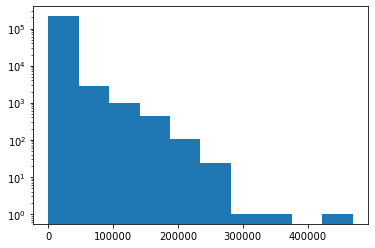

In [99]:
plt.hist( bound_df_degrees_filt['POP_SQMI'],log=True)